In [0]:
#import findspark
#findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [0]:
import pyspark.sql.types as typ
labels = [
    ('_c0',typ.IntegerType()), #it seems we has to add it here, otherwise the positions of columns would be incorrect
    ('birth_place',typ.IntegerType()),
    ('mothers_age',typ.IntegerType()),
    ('fathers_age',typ.IntegerType()),
    ('prental_care',typ.IntegerType()),
    ('cigarettes_before_pregnancy',typ.IntegerType()),
    ('cigarettes_1_trimester',typ.IntegerType()),
    ('cigarettes_2_trimester',typ.IntegerType()),
    ('cigarettes_3_trimester',typ.IntegerType()),
    ('mothers_height',typ.IntegerType()),
    ('bmi',typ.DecimalType()),
    ('prepregnancy_weight',typ.DecimalType()), #note: it has be Decimal, otherwise the value will become null
    ('delivery_weight',typ.IntegerType()),
    ('weight_gain',typ.IntegerType()),
    ('prepregnancy_diabetes',typ.StringType()),
    ('gestational_diabetes',typ.StringType()),
    ('prepregnancy_hypertension',typ.StringType()),
    ('gestational_hypertension',typ.StringType()),
    ('hypertension_eclampsia',typ.StringType()),
    ('previous_preterm_birth',typ.StringType()),
    ('infant_sex',typ.StringType()),
    ('infant_live',typ.StringType()),
]
schema = typ.StructType([
    typ.StructField(e[0],e[1],False) for e in labels
])
births = spark.read.csv('/FileStore/tables/nat18.csv', header = True, schema = schema)
#births = spark.read.csv('nat18.csv', header = True, schema = schema)

In [0]:
#check if our dataset contains any missing values
bool(births.head(1)) #if the result is False，then the dataset has missing values，otherwise no.

Out[5]: True

In [0]:
#filter out unknown any cases
births = births.filter((births.infant_live != 'U'))
births = births.filter((births.prepregnancy_diabetes != 'U'))
births = births.filter((births.gestational_diabetes != 'U'))
births = births.filter((births.prepregnancy_hypertension != 'U'))
births = births.filter((births.gestational_hypertension!= 'U'))
births = births.filter((births.hypertension_eclampsia!= 'U'))
births = births.filter((births.previous_preterm_birth!= 'U'))
births = births.filter((births.fathers_age!= 99))
births = births.filter((births.cigarettes_before_pregnancy!= 99))
births = births.filter((births.cigarettes_1_trimester!= 99))
births = births.filter((births.cigarettes_2_trimester!= 99))
births = births.filter((births.cigarettes_3_trimester!= 99))
births = births.filter((births.mothers_height!= 99))
births = births.filter((births.bmi!= 100))
births = births.filter((births.prepregnancy_weight!= 999))
births = births.filter((births.delivery_weight!= 999))
births = births.filter((births.weight_gain!= 99))

In [0]:
births.groupby('infant_live').count().show() #The result show our contains imbalaced classes

+-----------+-------+
infant_live| count|
+-----------+-------+
 Y|3224846|
 N| 2213|
+-----------+-------+

In [0]:
#Basical dataset statistical check
#if the dataset contains duplicate rows:
print('Count of rows: {0}'.format(births.count()))
print('Count of distinct rows: {0}'.format(births.distinct().count()))
#the results show our dataset contains no same rows

Count of rows: 3227059
Count of distinct rows: 3227059

In [0]:
#For numerical data, apply the describe() to get statistical summay.
numerical = ['mothers_age', 'fathers_age', 'cigarettes_before_pregnancy','cigarettes_1_trimester'
            ,'cigarettes_2_trimester','cigarettes_3_trimester','mothers_height','bmi'
            ,'prepregnancy_weight','delivery_weight','weight_gain']
desc = births.describe(numerical)
desc.toPandas()

,summary,mothers_age,fathers_age,cigarettes_before_pregnancy,cigarettes_1_trimester,cigarettes_2_trimester,cigarettes_3_trimester,mothers_height,bmi,prepregnancy_weight,delivery_weight,weight_gain
0,count,3227059,3227059,3227059,3227059,3227059,3227059,3227059,3227059,3227059,3227059,3227059
1,mean,29.369372236454307,31.787807412259895,0.9047463960218887,0.536430229506185,0.4000633394059421,0.35471523762038437,64.14300017446226,27.0720,158.3142,187.8532930448436,29.630798817127296
2,stddev,5.6560968024642735,6.794544600008508,4.268990604512939,3.0017986187169283,2.466927699787358,2.315872797492891,2.822443566919063,6.599992026459632,40.89583149538059,40.43973722280019,14.838047763424326
3,min,12,11,0,0,0,0,36,13,75,100,0
4,max,50,95,98,98,98,98,78,70,375,400,98


In [0]:
#feature engineering - covert target data to dummy variable
import pyspark.sql.functions as fn
#1.
categ = births.select('infant_live').distinct().rdd.flatMap(lambda x:x).collect()
exprs = [fn.when(fn.col('infant_live') == Y,1).otherwise(0)\
            .alias(str(Y)) for Y in categ]
births = births.select(exprs+births.columns)
#drop useless columns and rename target column
births = births.drop('N')
births = births.drop('_c0')
births = births.drop('infant_live')
births = births.withColumnRenamed('Y','infant_live_encoded')

In [0]:
births.printSchema()

root
-- infant_live_encoded: integer (nullable = false)
-- birth_place: integer (nullable = true)
-- mothers_age: integer (nullable = true)
-- fathers_age: integer (nullable = true)
-- prental_care: integer (nullable = true)
-- cigarettes_before_pregnancy: integer (nullable = true)
-- cigarettes_1_trimester: integer (nullable = true)
-- cigarettes_2_trimester: integer (nullable = true)
-- cigarettes_3_trimester: integer (nullable = true)
-- mothers_height: integer (nullable = true)
-- bmi: decimal(10,0) (nullable = true)
-- prepregnancy_weight: decimal(10,0) (nullable = true)
-- delivery_weight: integer (nullable = true)
-- weight_gain: integer (nullable = true)
-- prepregnancy_diabetes: string (nullable = true)
-- gestational_diabetes: string (nullable = true)
-- prepregnancy_hypertension: string (nullable = true)
-- gestational_hypertension: string (nullable = true)
-- hypertension_eclampsia: string (nullable = true)
-- previous_preterm_birth: string (nullable = true)
-- infant_sex: string (nullable = true)

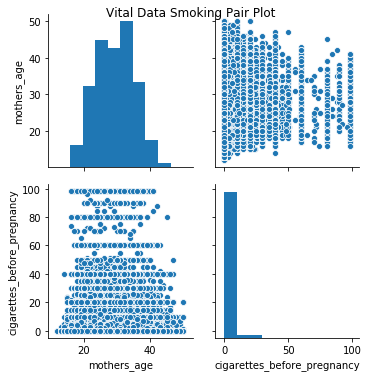

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.pairplot(births.toPandas()[['mothers_age','cigarettes_before_pregnancy']])
ax.fig.suptitle("Vital Data Smoking Pair Plot", y=1.01)

In [0]:
#check the ratio of the classes
import pyspark.sql.functions as fn
births_v1 = births
major_df = births_v1.filter(fn.col("infant_live_encoded")==1)
minor_df = births_v1.filter(fn.col("infant_live_encoded")==0)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 1457

In [0]:
#Since the ratio and the dataset size are fairly large, we decided to perform undersampling:
sampled_majority_df = major_df.sample(False, 1/ratio)
combined_df = sampled_majority_df.unionAll(minor_df)
combined_df.groupby('infant_live_encoded').count().show()

+-------------------+-----+
infant_live_encoded|count|
+-------------------+-----+
 1| 2218|
 0| 2213|
+-------------------+-----+

In [0]:
#first build pipelines
import pyspark.ml.feature as ft
from pyspark.ml import Pipeline
#Feature engineering on categrical data by create multiple pipelines
#1.
infant_sex_pipe = Pipeline(stages=[ft.StringIndexer(inputCol='infant_sex', handleInvalid='skip',outputCol = "indexed_sex"), 
                                 ft.OneHotEncoder(inputCol='indexed_sex',outputCol = "infant_sex_encoded")])
#2.
prepregnancy_diabetes_pipe = Pipeline(stages=[ft.StringIndexer(inputCol='prepregnancy_diabetes', handleInvalid='skip',outputCol = "indexed_prepregnancy_diabetes"), 
    ft.OneHotEncoder(inputCol='indexed_prepregnancy_diabetes',outputCol = "prepregnancy_diabetes_encoded")])
#3.
gestational_diabetes_pipe = Pipeline(stages=[ft.StringIndexer(inputCol='gestational_diabetes', handleInvalid='skip',outputCol = "indexed_gestational_diabetes"), 
    ft.OneHotEncoder(inputCol='indexed_gestational_diabetes',outputCol = "gestational_diabetes_encoded")])
#4.
prepregnancy_hypertension_pipe = Pipeline(stages=[ft.StringIndexer(inputCol='prepregnancy_hypertension', handleInvalid='skip',outputCol = "indexed_prepregnancy_hypertension"), 
    ft.OneHotEncoder(inputCol='indexed_prepregnancy_hypertension',outputCol = "prepregnancy_hypertension_encoded")])
#5.
gestational_hypertension_pipe = Pipeline(stages=[ft.StringIndexer(inputCol='gestational_hypertension', handleInvalid='skip',outputCol = "indexed_gestational_hypertension"), 
    ft.OneHotEncoder(inputCol='indexed_gestational_hypertension',outputCol = "gestational_hypertension_encoded")])
#6.
hypertension_eclampsia_pipe = Pipeline(stages=[ft.StringIndexer(inputCol='hypertension_eclampsia', handleInvalid='skip',outputCol = "indexed_hypertension_eclampsia"), 
    ft.OneHotEncoder(inputCol='indexed_hypertension_eclampsia',outputCol = "hypertension_eclampsia_encoded")])
#7.
previous_preterm_birth_pipe = Pipeline(stages=[ft.StringIndexer(inputCol='previous_preterm_birth', handleInvalid='skip',outputCol = "indexed_previous_preterm_birth"), 
    ft.OneHotEncoder(inputCol='indexed_previous_preterm_birth',outputCol = "previous_preterm_birth_encoded")])

In [0]:
#numerical data
numerical_pipe2 = Pipeline(stages = [ft.VectorAssembler(inputCols=['birth_place', 'mothers_age', 'fathers_age', 'prental_care', 'cigarettes_before_pregnancy', 'cigarettes_1_trimester'
                                    ,'cigarettes_2_trimester','cigarettes_3_trimester','mothers_height'
                                    ,'bmi','prepregnancy_weight','delivery_weight','weight_gain'], outputCol = 'num_features'),
                                   ft.StandardScaler(inputCol="num_features", outputCol="scaledFeatures",withMean = True, withStd = True)]) 

In [0]:
#final feature engineering pipeline
all_features = Pipeline(stages = [numerical_pipe2,
                                 infant_sex_pipe,
                                 prepregnancy_diabetes_pipe,
                                 gestational_diabetes_pipe,
                                 prepregnancy_hypertension_pipe,
                                 gestational_hypertension_pipe,
                                 hypertension_eclampsia_pipe,
                                 previous_preterm_birth_pipe,
                                 ft.VectorAssembler(inputCols = ['scaledFeatures',
                                                                'infant_sex_encoded',
                                                                'prepregnancy_diabetes_encoded',
                                                                'gestational_diabetes_encoded',
                                                                'prepregnancy_hypertension_encoded',
                                                                'gestational_hypertension_encoded',
                                                                'hypertension_eclampsia_encoded',
                                                                'previous_preterm_birth_encoded'],
                                                   outputCol = 'features')])

In [0]:
#build a logistic regression model
import pyspark.ml.classification as cl
logistic = cl.LogisticRegression(featuresCol = 'features',labelCol ='infant_live_encoded')

In [0]:
#build a simple pipeline
pipeline = Pipeline(stages = [all_features, logistic])

In [0]:
import pyspark.ml.evaluation as ev
#Binary Classification evaluation
evaluator = ev.BinaryClassificationEvaluator(
                rawPredictionCol = 'probability',
                labelCol = 'infant_live_encoded')
#test the undersampling dataset performance
train, val = combined_df.randomSplit([0.7,0.3],seed = 666)
model = pipeline.fit(train)
test_model = model.transform(val)
#print out the results:
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))

0.608773831391833
0.5915349479839578

In [0]:
#the undersampling dataset had poor performances, so we would like to try the original dataset
births_v1 = births
#split dataset into training and testing sets
births_train, births_val = births_v1.randomSplit([0.7,0.3],seed = 666)
#fit and transform 
model = pipeline.fit(births_train)

In [0]:
#evaluate perfromance on training data:
lr_summary = model.stages[-1].summary
#accuracy:
print('The training model Accuracy: ',lr_summary.accuracy)
#areaunderROC:
print('The training model ROC: ',lr_summary.areaUnderROC)
#weightedRecall
print('The training model Recall: ',lr_summary.weightedRecall)
#weightedPrecision
print('The training model Precision: ',lr_summary.weightedPrecision)

The training model Accuracy: 0.9993125084940394
The training model ROC: 0.6170216008047416
The training model Recall: 0.9993125084940394
The training model Precision: 0.9986254896326496

In [0]:
#evaluate perfromance on testing data:
test_model2 = model.transform(births_val)
#rawPredictionCol can be either rawPredictionCol or probability
print('The testing model ROC:', evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderROC'}))
print('The testing model PR:',evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))
#it seems we gave up a little bit of  ROC score but gained lots of PR score, so we would like to do our project with the original dataset
true_pos = test_model.filter(test_model['infant_live_encoded']==1).filter(test_model['prediction']==1).count()
actual_pos = test_model.filter(test_model['infant_live_encoded']==1).count()
pred_pos = test_model.filter(test_model['prediction']==1).count()
#The testing set recall:
print('The testing model Recall: ',float(true_pos)/(actual_pos))
#The testing set precision:
print('The testing model Precision: ',float(true_pos)/(pred_pos))

The testing model ROC: 0.608773831391833
The testing model PR: 0.5915349479839579
The testing model Recall: 0.6330827067669172
The testing model Precision: 0.5863509749303621

In [0]:
#check the most important features
lr_model = model.stages[-1]
pd.DataFrame(pd.DataFrame(list(zip(births.columns[1:], lr_model.coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight'))

,column,weight
10,prepregnancy_weight,-0.484368
15,prepregnancy_hypertension,-0.340879
11,delivery_weight,-0.306996
13,prepregnancy_diabetes,-0.250167
0,birth_place,-0.097132
3,prental_care,-0.080528
1,mothers_age,-0.044053
6,cigarettes_2_trimester,-0.031984
7,cigarettes_3_trimester,-0.031613
2,fathers_age,-0.029338


In [0]:
#we want to check other classification models, like random forest
#second model: random forest
birth_v2 = births #v3 is for rf

In [0]:
#first we converted our target type to Double
birth_v2 = birth_v2.withColumn('infant_live_encoded', fn.col('infant_live_encoded').cast(typ.DoubleType()))

In [0]:
#build rf model and check the performance
train2, val2 = birth_v2.randomSplit([0.7,0.3],seed = 666)
rf = cl.RandomForestClassifier(numTrees = 5,
                              maxDepth = 5,
                              labelCol = 'infant_live_encoded')
rf_pipe = Pipeline(stages = [all_features, rf])
model3 = rf_pipe.fit(train2)

In [0]:
#evaluate perfromance on testing data:
test_model3 = model3.transform(val2)
print('The testing model ROC:',evaluator.evaluate(test_model3, {evaluator.metricName: 'areaUnderROC'}))
print('The testing model PR:',evaluator.evaluate(test_model3, {evaluator.metricName: 'areaUnderPR'}))
true_pos = test_model3.filter(test_model3['infant_live_encoded']==1).filter(test_model3['prediction']==1).count()
actual_pos = test_model3.filter(test_model3['infant_live_encoded']==1).count()
pred_pos = test_model3.filter(test_model3['prediction']==1).count()
#The testing set recall:
print('The testing model Recall: ',float(true_pos)/(actual_pos))
#The testing set precision:
print('The testing model Precision: ',float(true_pos)/(pred_pos))

The testing model ROC: 0.5711593245256583
The testing model PR: 0.9996135001020867
The testing model Recall: 1.0
The testing model Precision: 0.9993182677389834

In [0]:
#rf_model.featureImportances
rf_model = model3.stages[-1]
pd.DataFrame(list(zip(birth_v2.columns[1:], rf_model.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight')

,column,weight
19,infant_sex,0.000000
17,hypertension_eclampsia,0.000000
2,fathers_age,0.000000
3,prental_care,0.000000
4,cigarettes_before_pregnancy,0.000000
5,cigarettes_1_trimester,0.000000
7,cigarettes_3_trimester,0.000000
18,previous_preterm_birth,0.000000
15,prepregnancy_hypertension,0.000000
11,delivery_weight,0.000000


In [0]:
#general compare of the lr and rf models:
bce = ev.BinaryClassificationEvaluator(
                rawPredictionCol = 'probability',
                labelCol = 'infant_live_encoded')
print("lr model overall performance: ", bce.evaluate(test_model))
print("rf model overall performance: ", bce.evaluate(test_model3))

lr model overall performance: 0.608773831391833
rf model overall performance: 0.5711593245256583

In [0]:
#logistic regression model hyperparameters tuning and cross-validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [0]:
#use ParamgridBuilder and CrossValidator for hyperparameter tuning
#our logistic regression model has better performance.gi
lr = cl.LogisticRegression(featuresCol = 'features',labelCol = 'infant_live_encoded')
paramGrid = (ParamGridBuilder()
            .addGrid(lr.maxIter, [3, 5, 10]) 
            .addGrid(lr.regParam, [0.1, 0.3, 0.5])
            .addGrid(lr.fitIntercept, [False, True])
            .addGrid(lr.elasticNetParam, [0.01, 0.2, 0.3])
            .build())

lr_evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol = 'probability',
                labelCol = 'infant_live_encoded')

cv = CrossValidator(estimator=lr, estimatorParamMaps= paramGrid
                    ,evaluator=lr_evaluator, numFolds=3)
#tuning
pipeline = Pipeline(stages = [all_features])
data_transformer = pipeline.fit(births_train)
cv_model = cv.fit(data_transformer.transform(births_train))
data_train = data_transformer.transform(births_val)
results = cv_model.transform(data_train)

/databricks/spark/python/pyspark/ml/util.py:762: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [0]:
#get the best model hyperparameters:
results = [
  (
  [
    {key.name:paramValue}
    for key, paramValue in zip(params.keys(),params.values())
  ],metric)
  for params, metric in zip(cv_model.getEstimatorParamMaps(),
                            cv_model.avgMetrics)
]
sorted(results, key = lambda e1:e1[1],
      reverse = True)[0]

Out[36]: ([{'maxIter': 5},
 {'regParam': 0.3},
 {'fitIntercept': False},
 {'elasticNetParam': 0.2}],
 0.5288742054445195)

In [0]:
#best model performance
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderPR'}))

0.5372320926801103
0.9993720439866127

In [0]:
#accuracy rate as well:
results.select(fn.avg(fn.expr('prediction = infant_live_encoded ').cast('float'))).show()

+------------------------------------------------------+
avg(CAST((prediction = infant_live_encoded) AS FLOAT))|
+------------------------------------------------------+
 0.9993182677389834|
+------------------------------------------------------+

In [0]:
#for selecting best model, another way is train-validation split
#using ChiSqSelector to select top 7 features to limit the model complexity
from pyspark.ml.tuning import TrainValidationSplit
selector = ft.ChiSqSelector(
                numTopFeatures = 7,
                featuresCol = 'features',
                outputCol = 'selectedFeatures',
                labelCol = 'infant_live_encoded')
lr_2 = cl.LogisticRegression(labelCol = 'infant_live_encoded',
                                featuresCol = 'selectedFeatures')
pipeline = Pipeline(stages = [all_features, selector])
data_transformer = pipeline.fit(train2)
tvs = TrainValidationSplit(estimator = lr_2, 
                           estimatorParamMaps= paramGrid
                        ,evaluator = lr_evaluator)
tvsModel = tvs.fit(data_transformer.transform(train2))
data_train = data_transformer.transform(val2)
results = tvsModel.transform(data_train)

In [0]:
#best model performance
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderPR'}))

0.6106643590355095
0.9995200610442928

In [0]:
#general performance
print("lr model overall performance: ", bce.evaluate(results))

lr model overall performance: 0.6106766498635637

In [0]:
#get the top 7 features select by the ChiSqSelector:
pd.DataFrame(pd.DataFrame(list(zip(births.columns[1:], tvsModel.bestModel.coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight'))

,column,weight
0,birth_place,-0.093014
1,mothers_age,-0.054386
3,prental_care,-0.028136
2,fathers_age,-0.011364
4,cigarettes_before_pregnancy,0.331937
6,cigarettes_2_trimester,0.499588
5,cigarettes_1_trimester,0.919288


In [0]:
#roc curve
FPR = tvsModel.bestModel.summary.roc.select('FPR').collect()
TPR = tvsModel.bestModel.summary.roc.select('TPR').collect()

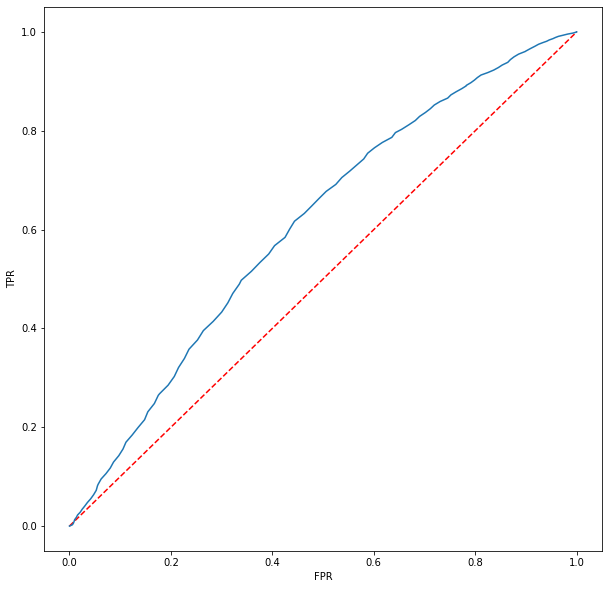

In [0]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'r--') # "random guess" line
plt.plot(FPR,TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [0]:
#PR curve
recall = tvsModel.bestModel.summary.pr.select('recall').collect()
precision = tvsModel.bestModel.summary.pr.select('precision').collect()

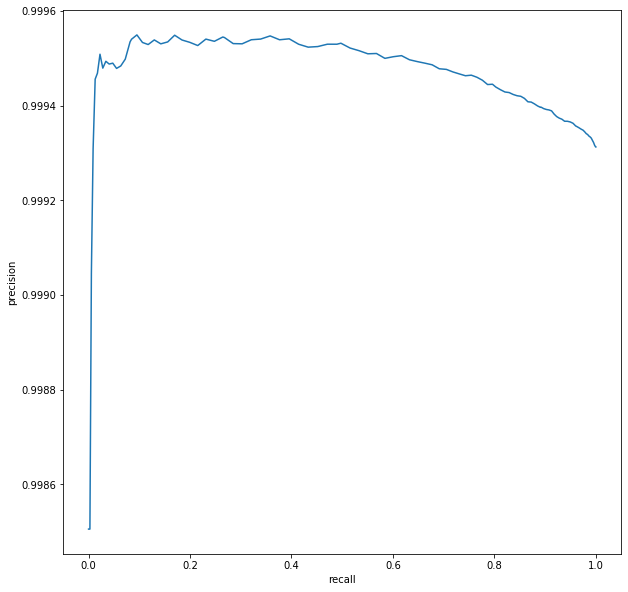

In [0]:
plt.figure(figsize=(10,10))
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()